In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import streamlit as st
from joblib import load
from confluent_kafka import Consumer, KafkaError
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
def merge_csv_files(directory):
    # List all CSV files in the directory
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    # Initialize an empty DataFrame to store the merged data
    merged_df = pd.DataFrame()
    count=1
    # Flag to indicate whether to include headers
    include_headers = True
    flag=0 if include_headers else None
    # Iterate over each CSV file and merge into the DataFrame
    for file in csv_files:
        file_path = os.path.join(directory, file)
        # Skip headers for all files except the first one
        df = pd.read_csv(file_path, header=flag)
        
        merged_df = pd.concat([merged_df, df], ignore_index=True)
        include_headers = False  # Headers only for the first file
        if count%5==0:
            print(count/len(csv_files))
        count+=1

    return merged_df

In [3]:

# def merge_csv_files(directory):
#     # List all CSV files in the directory
#     csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

#     # Initialize an empty DataFrame to store the merged data
#     merged_df = pd.DataFrame()
#     count=1
#     # Flag to indicate whether to include headers
#     include_headers = True
#     flag=0 if include_headers else None
#     # Iterate over each CSV file and merge into the DataFrame
#     for file in csv_files:
#         file_path = os.path.join(directory, file)
#         # Skip headers for all files except the first one
#         df = pd.read_csv(file_path, header=flag)
#         df=df[df['area_code'].str.contains('VIC', na=False) | df['area_code'].isnull()]
#         merged_df = pd.concat([merged_df, df], ignore_index=True)
#         include_headers = False  # Headers only for the first file
#         if count%5==0:
#             print(count/len(csv_files))
#         count+=1

#     return merged_df

# # Specify the directory containing CSV files
# csv_directory = './weather/obs/'

# # Merge CSV files and store the merged DataFrame
# obs_df = merge_csv_files(csv_directory)
# output_file_path = 'merged_weather_obs.pkl'  # Adjust the filename and path as needed
# obs_df.to_pickle(output_file_path)


In [4]:
obs_df_=pd.read_pickle("merged_weather_obs.pkl")
station_df_1=pd.read_csv("StationData_1.csv")
station_df_2=pd.read_csv("StationData_2.csv")
station_df_3=pd.read_csv("StationData_3.csv")
station_df = pd.concat([station_df_2, station_df_2, station_df_3], ignore_index=True)
station_df.drop_duplicates(subset=["WMO_NUM","station_number","LATITUDE","LONGITUDE"],keep='first', inplace=True)
obs_df=obs_df_.merge(station_df[["station_number","REGION"]], on='station_number', how='left')
obs_df.loc[~(obs_df["area_code"].isna()),"REGION"]=obs_df.loc[~(obs_df["area_code"].isna()),"area_code"].str[:3]
obs_df.rename(columns={'REGION': 'region'}, inplace=True)

In [5]:
(obs_df.loc[~(obs_df["area_code"].isna()),"region"]==obs_df_.loc[~(obs_df["area_code"].isna()),"area_code"].str[:3]).all()

True

In [6]:
obs_df_VIC=obs_df[obs_df["region"]=="VIC"]
obs_df_VIC.loc[:,"valid_start"]=pd.to_datetime(obs_df_VIC['valid_start'], unit='s')
obs_df_VIC.loc[:,"valid_end"]=pd.to_datetime(obs_df_VIC['valid_end'], unit='s')
obs_df_VIC.loc[:,"qc_valid_start"]=pd.to_datetime(obs_df_VIC['qc_valid_start'], unit='s')
obs_df_VIC.loc[:,"qc_valid_end"]=pd.to_datetime(obs_df_VIC['qc_valid_end'], unit='s')
obs_df_VIC.loc[:,"qc_valid_minutes_start"]=pd.to_datetime(obs_df_VIC['qc_valid_minutes_start'], unit='s')
obs_df_VIC.loc[:,"qc_valid_minutes_end"]=pd.to_datetime(obs_df_VIC['qc_valid_minutes_end'], unit='s')
obs_df_VIC=obs_df_VIC[obs_df_VIC.parameter.isin(["AIR_TEMP","AIR_TEMP_MAX","AIR_TEMP_MIN","PRCP","MaxT","MinT","T","Precip"])]
replacement_mapping = {
    'MaxT': 'AIR_TEMP_MAX',
    'MinT': 'AIR_TEMP_MIN',
    'T': 'AIR_TEMP',
    'Precip': 'PRCP'
}

obs_df_VIC['parameter'] = obs_df_VIC['parameter'].replace(replacement_mapping)

C:\Users\murca\AppData\Local\Temp\ipykernel_13360\2369487298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_VIC.loc[:,"valid_start"]=pd.to_datetime(obs_df_VIC['valid_start'], unit='s')
C:\Users\murca\AppData\Local\Temp\ipykernel_13360\2369487298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df_VIC.loc[:,"valid_end"]=pd.to_datetime(obs_df_VIC['valid_end'], unit='s')
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\pandas\core\tools\datetimes.py:557: RuntimeWarning: invalid value en

In [7]:
obs_df_VIC.parameter.value_counts()

AIR_TEMP_MAX    1978985
AIR_TEMP_MIN    1978985
AIR_TEMP        1974934
PRCP            1942446
Name: parameter, dtype: int64

In [8]:
obs_df_VIC[(obs_df_VIC.parameter=="PRCP")&(obs_df_VIC.value>0)&~(obs_df_VIC['valid_end'].dt.minute.eq(0))]

,station_number,area_code,parameter,valid_start,valid_end,value,unit,statistic,level,qc_valid_minutes,qc_valid_start,qc_valid_end,instantaneous,qc_valid_minutes_start,qc_valid_minutes_end,region
9159658,76031,VIC_PT119,PRCP,2015-04-30 22:00:00,2015-04-30 22:10:00,0.2,mm,sum,SFC,66.0,NaT,NaT,False,2015-04-30 21:54:00,2015-04-30 23:00:00,VIC
9160017,81123,VIC_PT113,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
9160258,83090,VIC_PT053,PRCP,2015-04-30 22:00:00,2015-04-30 22:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 22:00:00,2015-04-30 23:00:00,VIC
9160281,84016,VIC_PT024,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
9160545,85280,VIC_PT036,PRCP,2015-04-30 21:00:00,2015-04-30 21:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2015-04-30 21:00:00,2015-04-30 22:00:00,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15990244,90182,NaN,PRCP,2017-04-30 08:00:00,2017-04-30 08:10:00,0.6,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 08:00:00,2017-04-30 09:00:00,VIC
15990245,90182,NaN,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990314,90194,VIC_PT159,PRCP,2017-04-30 06:00:00,2017-04-30 06:10:00,0.4,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 06:00:00,2017-04-30 07:00:00,VIC
15990315,90194,VIC_PT159,PRCP,2017-04-30 07:00:00,2017-04-30 07:10:00,0.4,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 07:00:00,2017-04-30 08:00:00,VIC


In [9]:
obs_df_VIC[obs_df_VIC.valid_start=="2017-04-30 09:00:00"]


,station_number,area_code,parameter,valid_start,valid_end,value,unit,statistic,level,qc_valid_minutes,qc_valid_start,qc_valid_end,instantaneous,qc_valid_minutes_start,qc_valid_minutes_end,region
15980648,72160,VIC_PT084,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,12.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980672,76031,VIC_PT119,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,16.5,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980696,76064,VIC_PT074,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980720,77010,VIC_PT093,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.8,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
15980744,77094,VIC_PT127,AIR_TEMP,2017-04-30 09:00:00,2017-04-30 09:00:00,15.9,Celsius,first,SFC,NaN,NaT,NaT,True,2017-04-30 09:00:00,NaT,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15990221,90180,VIC_PT001,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990245,90182,NaN,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.2,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990269,90184,VIC_PT009,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC
15990293,90186,VIC_PT129,PRCP,2017-04-30 09:00:00,2017-04-30 09:10:00,0.0,mm,sum,SFC,60.0,NaT,NaT,False,2017-04-30 09:00:00,2017-04-30 10:00:00,VIC


In [10]:

def custom_agg(x):
    print(x)
    if (x['parameter']=='PRCP').any():
        return (x['value'] / (x['valid_end'] - x['valid_start'])).mean()
    else:
        return x['value'].mean()
df_obs=pd.DataFrame((obs_df_VIC.groupby(["valid_start","parameter"]).agg({"value":"mean"}))).reset_index()
df_obs=df_obs.pivot(index='valid_start', columns='parameter', values='value').reset_index()

In [11]:
df_obs.head()

parameter,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.0
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.0
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.0
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.0
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.0


In [12]:
demand_dir=r"C:\Users\murca\OneDrive\Masaüstü\DI PROJE\Demand"
demand_df = merge_csv_files(demand_dir)
# Convert 'SETTLEMENTDATE' to a datetime object
demand_df['SETTLEMENTDATE'] = pd.to_datetime(demand_df['SETTLEMENTDATE'])
# Check if 'SETTLEMENTDATE' is at half-hour
half_hour_mask = demand_df['SETTLEMENTDATE'].dt.minute == 30

# Add a date offset to the half-hour timestamps
demand_df.loc[half_hour_mask, 'SETTLEMENTDATE'] = demand_df['SETTLEMENTDATE'] + pd.DateOffset(minutes=30)

# Group by the rounded 'SETTLEMENTDATE' and sum the 'TOTALDEMAND' values
hourly_demand_df = demand_df.groupby(demand_df['SETTLEMENTDATE']).agg({'TOTALDEMAND': 'sum'}).reset_index()
hourly_demand_df.rename(columns={"SETTLEMENTDATE":"valid_start","TOTALDEMAND":"total_demand"},inplace=True)


0.13513513513513514
0.2702702702702703
0.40540540540540543
0.5405405405405406
0.6756756756756757
0.8108108108108109
0.9459459459459459


In [13]:
df=df_obs.merge(hourly_demand_df,how="left",on="valid_start")


In [14]:
df.head()

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.0,11174.56
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.0,11179.93
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.0,11205.02
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.0,11547.60
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.0,12290.58


In [15]:
df.tail(9)

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
26295,2018-04-30 15:00:00,7.708974,8.265385,6.817949,0.000000,10177.24
26296,2018-04-30 16:00:00,7.248052,7.793590,6.370513,0.000000,10393.05
26297,2018-04-30 17:00:00,6.876623,7.435897,6.134615,0.002632,10971.10
26298,2018-04-30 18:00:00,6.516883,7.091026,5.817949,0.000000,11759.23
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88
26303,2018-04-30 23:00:00,12.211538,15.865385,12.130769,0.000000,10132.50


In [16]:
df['valid_start'] = pd.to_datetime(df['valid_start'])
df = df.sort_values(by='valid_start')

In [17]:
df_new = df

In [18]:
df_new

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.000000,11174.56
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.000000,11179.93
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.000000,11205.02
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.000000,11547.60
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.000000,12290.58
...,...,...,...,...,...,...
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88


In [19]:
# Ensure valid_start column is of type datetime
df_new['valid_start'] = pd.to_datetime(df_new['valid_start'])

# Extract the day of the week
df_new['day_of_week'] = df_new['valid_start'].dt.day_name()

# One-hot encode the day_of_week column with only 6 dummy columns
df_encoded = pd.get_dummies(df_new, columns=['day_of_week'], drop_first=True)

In [20]:
df_encoded['week_of_year'] = df_encoded['valid_start'].dt.isocalendar().week

print(df_encoded.head())

          valid_start  AIR_TEMP  AIR_TEMP_MAX  AIR_TEMP_MIN  PRCP  \
0 2015-04-30 14:00:00  9.085135      9.381081      8.331081   0.0   
1 2015-04-30 15:00:00  8.638356      9.053425      7.994521   0.0   
2 2015-04-30 16:00:00  8.368493      8.739726      7.736986   0.0   
3 2015-04-30 17:00:00  8.087671      8.541096      7.498630   0.0   
4 2015-04-30 18:00:00  7.967123      8.350685      7.397260   0.0   

   total_demand  day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0      11174.56                   0                     0                   0   
1      11179.93                   0                     0                   0   
2      11205.02                   0                     0                   0   
3      11547.60                   0                     0                   0   
4      12290.58                   0                     0                   0   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  \
0                     1    

In [21]:
df_encoded['week_of_year'].unique()

<IntegerArray>
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,
  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]
Length: 53, dtype: UInt32

In [22]:
# Define the special holidays
special_holidays = [
    "1-1",  # New Year's Day
    "2-1",  # New Year's Day (additional day)
    "26-1",  # Australia Day
    "13-3",  # Labour Day
    "7-4",  # Good Friday
    "8-4",  # Easter Saturday
    # Since you did not provide a date for "Easter Sunday", I'm omitting it.
    "10-4",  # Easter Monday
    "25-4",  # Anzac Day
    "12-6",  # King's Birthday
    # Omitting the AFL Grand Final date since it's TBC.
    "7-11",  # Melbourne Cup
    "25-12",  # Christmas Day
    "26-12"  # Boxing Day
]



In [23]:
def format_date(date):
    formatted = date.strftime("%d-%m")
    day, month = formatted.split('-')
    return f"{int(day)}-{int(month)}"

In [24]:
# Create a new feature 'is_special_day' based on whether the date is in the special_holidays list
df_encoded['is_special_day'] = df_encoded['valid_start'].apply(lambda x: 1 if format_date(x) in special_holidays else 0)

print(df_encoded[['valid_start', 'is_special_day']].head())

          valid_start  is_special_day
0 2015-04-30 14:00:00               0
1 2015-04-30 15:00:00               0
2 2015-04-30 16:00:00               0
3 2015-04-30 17:00:00               0
4 2015-04-30 18:00:00               0


In [25]:
df_encoded[df_encoded['is_special_day'] == 1]

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_of_year,is_special_day
1018,2015-06-12 00:00:00,8.229730,10.009459,8.031081,0.000000,11955.18,0,0,0,0,0,0,24,1
1019,2015-06-12 01:00:00,9.748649,11.312162,9.518919,0.000000,11166.66,0,0,0,0,0,0,24,1
1020,2015-06-12 02:00:00,11.072603,12.478082,10.793151,0.000000,10377.58,0,0,0,0,0,0,24,1
1021,2015-06-12 03:00:00,12.086301,13.204110,11.750685,0.000000,9774.11,0,0,0,0,0,0,24,1
1022,2015-06-12 04:00:00,12.823288,13.520548,12.428767,0.000000,9448.73,0,0,0,0,0,0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,2018-04-25 19:00:00,9.892208,10.256410,9.317949,0.010526,10697.95,0,0,0,0,0,1,17,1
26180,2018-04-25 20:00:00,9.716883,10.279487,9.110256,0.036842,10248.83,0,0,0,0,0,1,17,1
26181,2018-04-25 21:00:00,9.736364,11.176923,9.465385,0.026316,9626.11,0,0,0,0,0,1,17,1
26182,2018-04-25 22:00:00,11.094805,13.146154,11.008974,0.000000,9141.56,0,0,0,0,0,1,17,1


In [26]:
def get_season(date):
    month = date.month
    if 12 <= month <= 2:
        return 'summer'
    elif 3 <= month <= 5:
        return 'autumn'
    elif 6 <= month <= 8:
        return 'winter'
    elif 9 <= month <= 11:
        return 'spring'


In [27]:
# Add a 'season' column to the dataframe
df_encoded['season'] = df_encoded['valid_start'].apply(get_season)

# One-hot encode the 'season' column
df_encoded = pd.get_dummies(df_encoded, columns=['season'], prefix='season')

print(df_encoded.head())

          valid_start  AIR_TEMP  AIR_TEMP_MAX  AIR_TEMP_MIN  PRCP  \
0 2015-04-30 14:00:00  9.085135      9.381081      8.331081   0.0   
1 2015-04-30 15:00:00  8.638356      9.053425      7.994521   0.0   
2 2015-04-30 16:00:00  8.368493      8.739726      7.736986   0.0   
3 2015-04-30 17:00:00  8.087671      8.541096      7.498630   0.0   
4 2015-04-30 18:00:00  7.967123      8.350685      7.397260   0.0   

   total_demand  day_of_week_Monday  day_of_week_Saturday  day_of_week_Sunday  \
0      11174.56                   0                     0                   0   
1      11179.93                   0                     0                   0   
2      11205.02                   0                     0                   0   
3      11547.60                   0                     0                   0   
4      12290.58                   0                     0                   0   

   day_of_week_Thursday  day_of_week_Tuesday  day_of_week_Wednesday  \
0                     1    

In [28]:
# Extract hour from the 'valid_start' column
df_encoded['hour_of_day'] = df_encoded['valid_start'].dt.hour

print(df_encoded[['valid_start', 'hour_of_day']].head())

          valid_start  hour_of_day
0 2015-04-30 14:00:00           14
1 2015-04-30 15:00:00           15
2 2015-04-30 16:00:00           16
3 2015-04-30 17:00:00           17
4 2015-04-30 18:00:00           18


In [29]:
df_encoded

,valid_start,AIR_TEMP,AIR_TEMP_MAX,AIR_TEMP_MIN,PRCP,total_demand,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,week_of_year,is_special_day,season_autumn,season_spring,season_winter,hour_of_day
0,2015-04-30 14:00:00,9.085135,9.381081,8.331081,0.000000,11174.56,0,0,0,1,0,0,18,0,1,0,0,14
1,2015-04-30 15:00:00,8.638356,9.053425,7.994521,0.000000,11179.93,0,0,0,1,0,0,18,0,1,0,0,15
2,2015-04-30 16:00:00,8.368493,8.739726,7.736986,0.000000,11205.02,0,0,0,1,0,0,18,0,1,0,0,16
3,2015-04-30 17:00:00,8.087671,8.541096,7.498630,0.000000,11547.60,0,0,0,1,0,0,18,0,1,0,0,17
4,2015-04-30 18:00:00,7.967123,8.350685,7.397260,0.000000,12290.58,0,0,0,1,0,0,18,0,1,0,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2018-04-30 19:00:00,6.296104,6.907692,5.715385,0.002632,12282.59,1,0,0,0,0,0,18,0,1,0,0,19
26300,2018-04-30 20:00:00,6.217949,6.692308,5.466667,0.005263,11889.42,1,0,0,0,0,0,18,0,1,0,0,20
26301,2018-04-30 21:00:00,6.024359,8.383333,5.729487,0.005263,11401.30,1,0,0,0,0,0,18,0,1,0,0,21
26302,2018-04-30 22:00:00,8.298718,12.328205,8.228205,0.005263,10901.88,1,0,0,0,0,0,18,0,1,0,0,22


In [74]:
# Number of hours to exclude for the test set
hours_to_exclude = 168

# Adjusting the training set to end 168 hours before the full dataset
train_size = len(df_encoded) - hours_to_exclude

# Splitting the data
train_data = df_encoded.iloc[:train_size]
test_data = df_encoded.iloc[train_size:]

# Extracting the 'total_demand' series for ARIMA modeling
train_series = train_data['total_demand']
test_series = test_data['total_demand']

In [77]:
# Fit the ARIMA model
model = ARIMA(train_series, order=(1, 1, 1))
model_fit = model.fit()

# Predictions for training set
train_pred = model_fit.get_prediction(start=train_series.index[0], end=train_series.index[-1])
train_pred_mean = train_pred.predicted_mean

# Calculating MAE and MAPE for training set
train_mae = mean_absolute_error(train_series, train_pred_mean)
train_mape = mean_absolute_percentage_error(train_series, train_pred_mean)

# Forecasting specific time points in the test set
forecast_1h = model_fit.forecast(steps=1)
forecast_8h = model_fit.forecast(steps=8)
forecast_168h = model_fit.forecast(steps=168)

# Extract actual values for comparison
actual_1h = test_series.iloc[0]
actual_8h = test_series.iloc[7]
actual_168h = test_series.iloc[167]

# Calculating MAE and MAPE for each forecast horizon in the test set
mae_1h = mean_absolute_error([actual_1h], [forecast_1h.iloc[0]])
mape_1h = mean_absolute_percentage_error([actual_1h], [forecast_1h.iloc[0]])

mae_8h = mean_absolute_error([actual_8h], [forecast_8h.iloc[-1]])
mape_8h = mean_absolute_percentage_error([actual_8h], [forecast_8h.iloc[-1]])

mae_168h = mean_absolute_error([actual_168h], [forecast_168h.iloc[-1]])
mape_168h = mean_absolute_percentage_error([actual_168h], [forecast_168h.iloc[-1]])

(train_mae, train_mape, mae_1h, mape_1h, mae_8h, mape_8h, mae_168h, mape_168h)

(317.27575302257566,
 0.03156758461731343,
 595.321574241254,
 0.06353193762092604,
 654.9635205620016,
 0.07193346174760838,
 1683.3610769380775,
 0.16613482131143129)

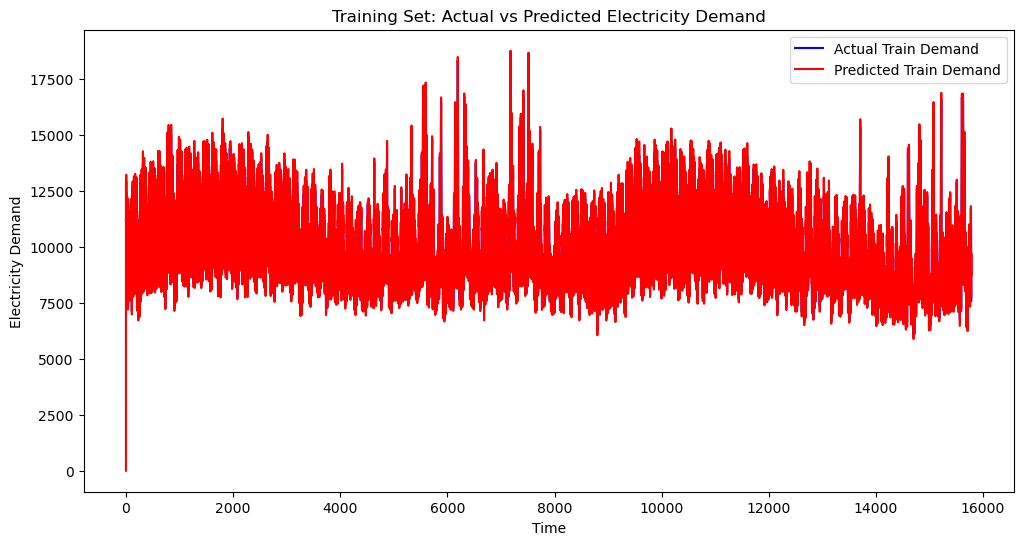

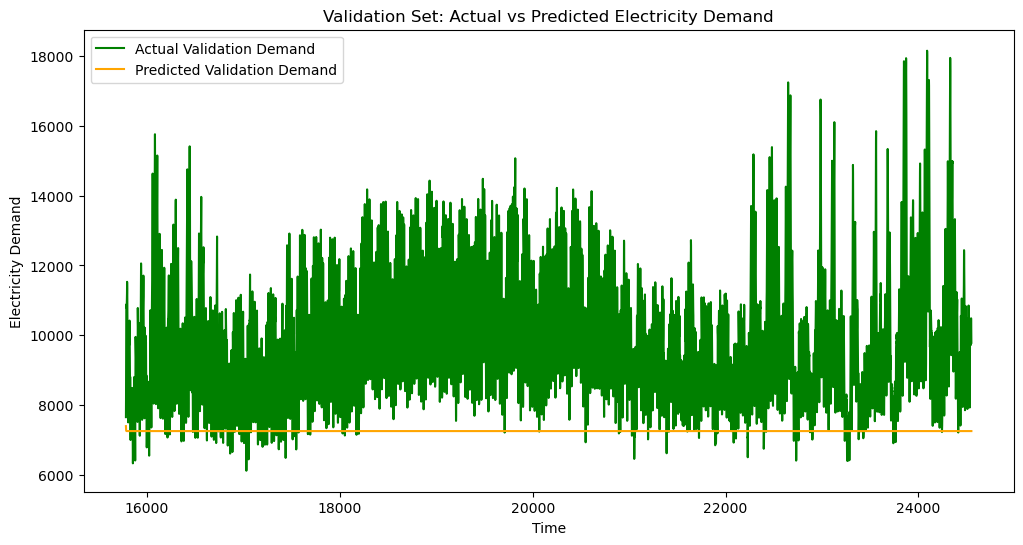

In [69]:
# Plotting the training actual values and predictions
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Actual Train Demand', color='blue')
plt.plot(train_pred_mean, label='Predicted Train Demand', color='red')
plt.title('Training Set: Actual vs Predicted Electricity Demand')
plt.xlabel('Time')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

# Plotting the validation actual values and predictions
plt.figure(figsize=(12, 6))
plt.plot(val_series, label='Actual Validation Demand', color='green')
plt.plot(val_pred_mean, label='Predicted Validation Demand', color='orange')
plt.title('Validation Set: Actual vs Predicted Electricity Demand')
plt.xlabel('Time')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

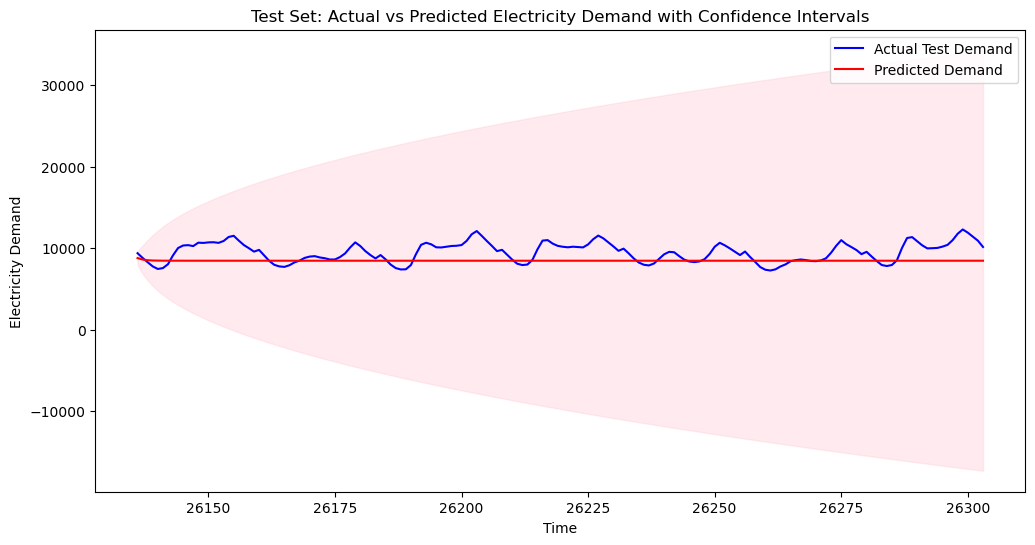

In [78]:
# Assuming you have already fitted the ARIMA model as 'model_fit'

# Forecasting for the test set with confidence intervals
forecast_result = model_fit.get_forecast(steps=len(test_series))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test_series, label='Actual Test Demand', color='blue')  # Actual values
plt.plot(forecast_mean, label='Predicted Demand', color='red')  # Predictions

# Plotting the confidence intervals
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)

plt.title('Test Set: Actual vs Predicted Electricity Demand with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

In [84]:
# Define the range of values for p, d, q
p_values = range(1, 4)
d_values = range(1, 4)
q_values = range(1, 4)

# Calculate total number of iterations
total_iterations = len(p_values) * len(d_values) * len(q_values)

# List to store the results
results_list = []

# Counter for completed trials
completed_trials = 0

# Iterate over all combinations of p, d, q
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train_series, order=(p, d, q))
                model_fit = model.fit()

                # Evaluate on training set
                train_pred = model_fit.predict(start=train_series.index[0], end=train_series.index[-1])
                train_mae = mean_absolute_error(train_series, train_pred)
                train_mape = mean_absolute_percentage_error(train_series, train_pred)

                # Evaluate on test set for specific time points
                forecast_1h = model_fit.forecast(steps=1)
                forecast_8h = model_fit.forecast(steps=8)
                forecast_168h = model_fit.forecast(steps=168)

                # Extract actual values for comparison
                actual_1h = test_series.iloc[0]
                actual_8h = test_series.iloc[7]
                actual_168h = test_series.iloc[167]

                # Calculate MAE and MAPE for each forecast horizon
                mae_1h = mean_absolute_error([actual_1h], [forecast_1h.iloc[0]])
                mape_1h = mean_absolute_percentage_error([actual_1h], [forecast_1h.iloc[0]])

                mae_8h = mean_absolute_error([actual_8h], [forecast_8h.iloc[-1]])
                mape_8h = mean_absolute_percentage_error([actual_8h], [forecast_8h.iloc[-1]])

                mae_168h = mean_absolute_error([actual_168h], [forecast_168h.iloc[-1]])
                mape_168h = mean_absolute_percentage_error([actual_168h], [forecast_168h.iloc[-1]])

                # Append the result as a dictionary
                results_list.append({
                    'p': p, 'd': d, 'q': q, 
                    'MAE_1h': mae_1h, 'MAPE_1h': mape_1h, 
                    'MAE_8h': mae_8h, 'MAPE_8h': mape_8h, 
                    'MAE_168h': mae_168h, 'MAPE_168h': mape_168h, 
                    'Train_MAE': train_mae, 'Train_MAPE': train_mape, 
                    'AIC': model_fit.aic, 'BIC': model_fit.bic
                })

                # Increment the completed trials counter
                completed_trials += 1

                # Print the progress
                progress = (completed_trials / total_iterations) * 100
                print(f"Completed {completed_trials} of {total_iterations} trials ({progress:.2f}%)")

            except Exception as e:
                print(f"Error for ARIMA({p},{d},{q}): {e}")

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
results_df



Completed 1 of 27 trials (3.70%)
Completed 2 of 27 trials (7.41%)
Completed 3 of 27 trials (11.11%)
Completed 4 of 27 trials (14.81%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 5 of 27 trials (18.52%)
Completed 6 of 27 trials (22.22%)
Completed 7 of 27 trials (25.93%)
Completed 8 of 27 trials (29.63%)
Completed 9 of 27 trials (33.33%)
Completed 10 of 27 trials (37.04%)
Completed 11 of 27 trials (40.74%)
Completed 12 of 27 trials (44.44%)
Completed 13 of 27 trials (48.15%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 14 of 27 trials (51.85%)
Completed 15 of 27 trials (55.56%)
Completed 16 of 27 trials (59.26%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 17 of 27 trials (62.96%)
Completed 18 of 27 trials (66.67%)
Completed 19 of 27 trials (70.37%)
Completed 20 of 27 trials (74.07%)
Completed 21 of 27 trials (77.78%)
Completed 22 of 27 trials (81.48%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 23 of 27 trials (85.19%)
Completed 24 of 27 trials (88.89%)
Completed 25 of 27 trials (92.59%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 26 of 27 trials (96.30%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 27 of 27 trials (100.00%)


,p,d,q,MAE_1h,MAPE_1h,MAE_8h,MAPE_8h,MAE_168h,MAPE_168h,Train_MAE,Train_MAPE,AIC,BIC
0,1,1,1,595.321574,0.063532,654.963521,0.071933,1683.361077,0.166135,317.275753,0.031568,391507.249085,391531.762177
1,1,1,2,582.508991,0.062165,586.777914,0.064445,1614.279971,0.159317,313.294516,0.031120,391420.770020,391453.454143
2,1,1,3,523.948514,0.055915,60.861984,0.006684,690.740626,0.068171,309.450973,0.030906,390048.448877,390089.304031
3,1,2,1,580.325397,0.061932,946.439877,0.103946,2031.937615,0.200537,332.841649,0.033024,392758.029714,392782.542692
4,1,2,2,595.700788,0.063572,656.671324,0.072121,1680.946601,0.165897,317.487331,0.031586,391494.903662,391527.587632
5,1,2,3,582.828707,0.062199,587.952914,0.064574,1611.450080,0.159038,313.500356,0.031138,391409.535391,391450.390353
6,1,3,1,827.648331,0.088326,5104.550050,0.560624,111065.391045,10.961302,358.446787,0.035812,398262.486609,398286.999472
7,1,3,2,859.907185,0.091768,5253.761863,0.577011,114075.416187,11.258368,353.119984,0.035317,397889.156870,397921.840687
8,1,3,3,595.101199,0.063508,652.226158,0.071633,2135.727743,0.210780,318.493123,0.031694,391621.700116,391662.554887
9,2,1,1,579.849867,0.061881,299.108979,0.032851,637.479299,0.062914,307.550422,0.030498,389120.603602,389153.287725


In [88]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Define the range of values for p, d, q
p_values = range(1, 4)
d_values = range(1, 4)
q_values = range(1, 4)

# Define the transformations
transformations = {'log': np.log, 'sqrt': np.sqrt}

# Calculate total number of iterations
total_iterations = (len(p_values) * len(d_values) * len(q_values))* 2

# List to store the results
results_list = []

# Counter for completed trials
completed_trials = 0


# Function to reverse the transformation for MAE and MAPE calculation
def inverse_transform(transformation, data):
    if transformation == 'log':
        return np.exp(data)
    elif transformation == 'sqrt':
        return np.power(data, 2)
    return data

# Iterate over all transformations
for transform_name, transform_function in transformations.items():
    # Apply the transformation
    transformed_train_series = transform_function(train_series)
    transformed_test_series = transform_function(test_series)

    # Iterate over all combinations of p, d, q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit the ARIMA model on transformed data
                    model = ARIMA(transformed_train_series, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluate on transformed training set
                    train_pred_transformed = model_fit.predict(start=transformed_train_series.index[0], end=transformed_train_series.index[-1])
                    train_mae = mean_absolute_error(inverse_transform(transform_name, transformed_train_series), inverse_transform(transform_name, train_pred_transformed))
                    train_mape = mean_absolute_percentage_error(inverse_transform(transform_name, transformed_train_series), inverse_transform(transform_name, train_pred_transformed))

                    # [Code to evaluate on the test set and calculate metrics for 1h, 8h, 168h...]
                    # Evaluate on test set for specific time points
                    forecast_1h = model_fit.forecast(steps=1)
                    forecast_8h = model_fit.forecast(steps=8)
                    forecast_168h = model_fit.forecast(steps=168)

                    # Extract actual values for comparison
                    actual_1h = test_series.iloc[0]
                    actual_8h = test_series.iloc[7]
                    actual_168h = test_series.iloc[167]

                    # Calculate MAE and MAPE for each forecast horizon
                    mae_1h = mean_absolute_error([actual_1h], [inverse_transform(transform_name, forecast_1h).iloc[0]])
                    mape_1h = mean_absolute_percentage_error([actual_1h], [inverse_transform(transform_name, forecast_1h).iloc[0]])

                    mae_8h = mean_absolute_error([actual_8h], [inverse_transform(transform_name, forecast_8h).iloc[-1]])
                    mape_8h = mean_absolute_percentage_error([actual_8h], [inverse_transform(transform_name, forecast_8h).iloc[-1]])

                    mae_168h = mean_absolute_error([actual_168h], [inverse_transform(transform_name, forecast_168h).iloc[-1]])
                    mape_168h = mean_absolute_percentage_error([actual_168h], [inverse_transform(transform_name, forecast_168h).iloc[-1]])
                    # Append the result as a dictionary
                    results_list.append({
                        'Transformation': transform_name,
                        'p': p, 'd': d, 'q': q, 
                        'MAE_1h': mae_1h, 'MAPE_1h': mape_1h, 
                        'MAE_8h': mae_8h, 'MAPE_8h': mape_8h, 
                        'MAE_168h': mae_168h, 'MAPE_168h': mape_168h, 
                        'Train_MAE': train_mae, 'Train_MAPE': train_mape, 
                        'AIC': model_fit.aic, 'BIC': model_fit.bic
                    })
                    # Increment the completed trials counter
                    completed_trials += 1

                    # Print the progress
                    progress = (completed_trials / total_iterations) * 100
                    print(f"Completed {completed_trials} of {total_iterations} trials ({progress:.2f}%)")
                except Exception as e:
                    print(f"Error for {transform_name} ARIMA({p},{d},{q}): {e}")

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
results_df


Completed 1 of 54 trials (1.85%)
Completed 2 of 54 trials (3.70%)
Completed 3 of 54 trials (5.56%)
Completed 4 of 54 trials (7.41%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 5 of 54 trials (9.26%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 6 of 54 trials (11.11%)
Completed 7 of 54 trials (12.96%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 8 of 54 trials (14.81%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 9 of 54 trials (16.67%)
Completed 10 of 54 trials (18.52%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 11 of 54 trials (20.37%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 12 of 54 trials (22.22%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 13 of 54 trials (24.07%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 14 of 54 trials (25.93%)
Completed 15 of 54 trials (27.78%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 16 of 54 trials (29.63%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 17 of 54 trials (31.48%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 18 of 54 trials (33.33%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 19 of 54 trials (35.19%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 20 of 54 trials (37.04%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 21 of 54 trials (38.89%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 22 of 54 trials (40.74%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 23 of 54 trials (42.59%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 24 of 54 trials (44.44%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 25 of 54 trials (46.30%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 26 of 54 trials (48.15%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 27 of 54 trials (50.00%)
Completed 28 of 54 trials (51.85%)
Completed 29 of 54 trials (53.70%)
Completed 30 of 54 trials (55.56%)
Completed 31 of 54 trials (57.41%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 32 of 54 trials (59.26%)
Completed 33 of 54 trials (61.11%)
Completed 34 of 54 trials (62.96%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 35 of 54 trials (64.81%)
Completed 36 of 54 trials (66.67%)
Completed 37 of 54 trials (68.52%)
Completed 38 of 54 trials (70.37%)
Completed 39 of 54 trials (72.22%)
Completed 40 of 54 trials (74.07%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 41 of 54 trials (75.93%)
Completed 42 of 54 trials (77.78%)
Completed 43 of 54 trials (79.63%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 44 of 54 trials (81.48%)
Completed 45 of 54 trials (83.33%)
Completed 46 of 54 trials (85.19%)
Completed 47 of 54 trials (87.04%)
Completed 48 of 54 trials (88.89%)
Completed 49 of 54 trials (90.74%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 50 of 54 trials (92.59%)
Completed 51 of 54 trials (94.44%)
Completed 52 of 54 trials (96.30%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed 53 of 54 trials (98.15%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 54 of 54 trials (100.00%)


,Transformation,p,d,q,MAE_1h,MAPE_1h,MAE_8h,MAPE_8h,MAE_168h,MAPE_168h,Train_MAE,Train_MAPE,AIC,BIC
0,log,1,1,1,570.081701,0.060838,595.526647,0.065406,1623.764979,0.160253,317.399731,0.031594,-89975.234389,-89950.721297
1,log,1,1,2,558.344113,0.059586,531.998541,0.058428,1559.440839,0.153905,312.957108,0.031115,-90108.160290,-90075.476168
2,log,1,1,3,509.348803,0.054357,24.208801,0.002659,772.481270,0.076238,308.769989,0.030802,-91614.202904,-91573.347751
3,log,1,2,1,556.022654,0.059338,844.745438,0.092777,1971.818181,0.194603,378.796452,0.037160,-88731.987398,-88707.474421
4,log,1,2,2,571.471216,0.060987,604.981228,0.066444,1700.926368,0.167868,362.160840,0.035597,-89953.349149,-89920.665180
5,log,1,2,3,559.788640,0.059740,540.367523,0.059348,1803.595394,0.178001,357.759538,0.035124,-90046.521650,-90005.666688
6,log,1,3,1,784.975992,0.083772,3782.118835,0.415383,10132.431117,0.999993,5140.501569,0.463335,-83137.661927,-83113.149064
7,log,1,3,2,741.316923,0.079112,3669.497628,0.403014,10132.377750,0.999988,5142.811385,0.463601,-83417.557046,-83384.873230
8,log,1,3,3,629.288615,0.067157,993.737215,0.109140,8184.291336,0.807727,5112.194977,0.460964,-87573.113520,-87532.258750
9,log,2,1,1,562.546164,0.060034,257.032364,0.028229,696.812609,0.068770,309.738246,0.030672,-92498.002047,-92465.317924


In [92]:
# Define the range of values for p, d, q and P, D, Q
p_values = d_values = q_values = P_values = D_values = Q_values = [0, 1]

# Define the seasonal periods
seasonal_periods = [24, 168]

# List to store the results
results_list = []
# Calculate the total number of iterations
total_iterations = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values) * len(seasonal_periods)
completed_trials = 0

# Iterate over all combinations of parameters and seasonal periods
for period in seasonal_periods:
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Fit the SARIMA model
                                model = SARIMAX(train_series, order=(p, d, q), seasonal_order=(P, D, Q, period))
                                model_fit = model.fit(disp=0)

                                # Evaluate on training set
                                train_pred = model_fit.predict(start=train_series.index[0], end=train_series.index[-1])
                                train_mae = mean_absolute_error(train_series, train_pred)
                                train_mape = mean_absolute_percentage_error(train_series, train_pred)

                                # Evaluate on test set for specific time points
                                forecast_1h = model_fit.forecast(steps=1)
                                forecast_8h = model_fit.forecast(steps=8)
                                forecast_168h = model_fit.forecast(steps=168)

                                # Extract actual values for comparison
                                actual_1h = test_series.iloc[0]
                                actual_8h = test_series.iloc[7]
                                actual_168h = test_series.iloc[167]

                                # Calculate MAE and MAPE for each forecast horizon
                                mae_1h = mean_absolute_error([actual_1h], [forecast_1h.iloc[0]])
                                mape_1h = mean_absolute_percentage_error([actual_1h], [forecast_1h.iloc[0]])

                                mae_8h = mean_absolute_error([actual_8h], [forecast_8h.iloc[-1]])
                                mape_8h = mean_absolute_percentage_error([actual_8h], [forecast_8h.iloc[-1]])

                                mae_168h = mean_absolute_error([actual_168h], [forecast_168h.iloc[-1]])
                                mape_168h = mean_absolute_percentage_error([actual_168h], [forecast_168h.iloc[-1]])

                                # Append the result as a dictionary
                                results_list.append({
                                    'Seasonal_Period': period,
                                    'p': p, 'd': d, 'q': q,
                                    'P': P, 'D': D, 'Q': Q,
                                    'Train_MAE': train_mae, 'Train_MAPE': train_mape,
                                    'MAE_1h': mae_1h, 'MAPE_1h': mape_1h,
                                    'MAE_8h': mae_8h, 'MAPE_8h': mape_8h,
                                    'MAE_168h': mae_168h, 'MAPE_168h': mape_168h,
                                    'AIC': model_fit.aic, 'BIC': model_fit.bic
                                })
                            # Increment the completed trials counter
                                completed_trials += 1

                                # Print the progress
                                progress = (completed_trials / total_iterations) * 100
                                print(f"Completed {completed_trials} of {total_iterations} trials ({progress:.2f}%)")
                            except Exception as e:
                                print(f"Error for SARIMA({p},{d},{q})({P},{D},{Q},{period}): {e}")

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)

Completed 1 of 128 trials (0.78%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Completed 2 of 128 trials (1.56%)
Completed 3 of 128 trials (2.34%)
Completed 4 of 128 trials (3.12%)
Completed 5 of 128 trials (3.91%)
Completed 6 of 128 trials (4.69%)
Completed 7 of 128 trials (5.47%)
Completed 8 of 128 trials (6.25%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 9 of 128 trials (7.03%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Completed 10 of 128 trials (7.81%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 11 of 128 trials (8.59%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 12 of 128 trials (9.38%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 13 of 128 trials (10.16%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 14 of 128 trials (10.94%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 15 of 128 trials (11.72%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Completed 16 of 128 trials (12.50%)
Completed 17 of 128 trials (13.28%)
Completed 18 of 128 trials (14.06%)
Completed 19 of 128 trials (14.84%)
Completed 20 of 128 trials (15.62%)
Completed 21 of 128 trials (16.41%)
Completed 22 of 128 trials (17.19%)
Completed 23 of 128 trials (17.97%)
Completed 24 of 128 trials (18.75%)
Completed 25 of 128 trials (19.53%)
Completed 26 of 128 trials (20.31%)
Completed 27 of 128 trials (21.09%)
Completed 28 of 128 trials (21.88%)
Completed 29 of 128 trials (22.66%)
Completed 30 of 128 trials (23.44%)
Completed 31 of 128 trials (24.22%)
Completed 32 of 128 trials (25.00%)
Completed 33 of 128 trials (25.78%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Completed 34 of 128 trials (26.56%)
Completed 35 of 128 trials (27.34%)
Completed 36 of 128 trials (28.12%)
Completed 37 of 128 trials (28.91%)
Completed 38 of 128 trials (29.69%)
Completed 39 of 128 trials (30.47%)
Completed 40 of 128 trials (31.25%)
Completed 41 of 128 trials (32.03%)


c:\Users\murca\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Completed 42 of 128 trials (32.81%)
Completed 43 of 128 trials (33.59%)
Completed 44 of 128 trials (34.38%)
Completed 45 of 128 trials (35.16%)
Completed 46 of 128 trials (35.94%)
Completed 47 of 128 trials (36.72%)
Completed 48 of 128 trials (37.50%)
Completed 49 of 128 trials (38.28%)
Completed 50 of 128 trials (39.06%)
Completed 51 of 128 trials (39.84%)
Completed 52 of 128 trials (40.62%)
Completed 53 of 128 trials (41.41%)
Completed 54 of 128 trials (42.19%)
Completed 55 of 128 trials (42.97%)
Completed 56 of 128 trials (43.75%)
Completed 57 of 128 trials (44.53%)
Completed 58 of 128 trials (45.31%)
Completed 59 of 128 trials (46.09%)
Completed 60 of 128 trials (46.88%)
Completed 61 of 128 trials (47.66%)
Completed 62 of 128 trials (48.44%)
Completed 63 of 128 trials (49.22%)
Completed 64 of 128 trials (50.00%)
Completed 65 of 128 trials (50.78%)


MemoryError: Unable to allocate 5.56 GiB for an array with shape (169, 169, 26136) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 988, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 5.56 GiB for an array with shape (169, 169, 26136) and data type float64


Error for SARIMA(0,0,0)(0,0,1,168): Memoryview is not initialized
Error for SARIMA(0,0,0)(0,1,0,168): Unable to allocate 5.56 GiB for an array with shape (169, 169, 26136) and data type float64


KeyboardInterrupt: 

In [94]:
results_df = pd.DataFrame(results_list)

# Display the results
results_df

,Seasonal_Period,p,d,q,P,D,Q,Train_MAE,Train_MAPE,MAE_1h,MAPE_1h,MAE_8h,MAPE_8h,MAE_168h,MAPE_168h,AIC,BIC
0,24,0,0,0,0,0,0,10125.581551,1.000000,9370.430000,1.000000,9105.130000,1.000000,10132.500000,1.000000,557053.157195,557061.328264
1,24,0,0,0,0,0,1,5225.983200,0.515279,4178.822506,0.445958,4578.817982,0.502883,10132.500000,1.000000,524160.999211,524177.341349
2,24,0,0,0,0,1,0,840.824433,0.082366,68.020000,0.007259,278.250000,0.030560,941.170000,0.092886,444627.690555,444635.860706
3,24,0,0,0,0,1,1,899.609009,0.089206,199.255912,0.021264,70.701032,0.007765,861.763412,0.085049,444567.319570,444583.659871
4,24,0,0,0,1,0,0,839.058096,0.081898,131.797729,0.014065,213.917137,0.023494,1373.313210,0.135535,445051.796158,445068.138296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,24,1,1,1,1,0,0,152.757122,0.015222,15.299460,0.001633,182.972986,0.020096,1283.910520,0.126712,354101.118524,354133.802647
61,24,1,1,1,1,0,1,151.041226,0.015096,28.321938,0.003022,1025.576039,0.112637,5309.799190,0.524036,359533.093693,359573.948846
62,24,1,1,1,1,1,0,149.256347,0.014960,11.397401,0.001216,301.823742,0.033149,1714.944075,0.169252,353013.546520,353046.226968
63,24,1,1,1,1,1,1,133.020402,0.013346,2.871119,0.000306,183.309786,0.020133,1355.280786,0.133756,345938.060420,345978.910979


In [95]:
# Find the index of the row with the minimum MAPE_168h
min_mape_168h_idx = results_df['MAPE_168h'].idxmin()

# Extract the row with the minimum MAPE_168h
min_mape_168h_row = results_df.loc[min_mape_168h_idx]

min_mape_168h_row

Seasonal_Period        24.000000
p                       0.000000
d                       1.000000
q                       1.000000
P                       0.000000
D                       1.000000
Q                       0.000000
Train_MAE             161.930147
Train_MAPE              0.016157
MAE_1h                 90.371859
MAPE_1h                 0.009644
MAE_8h                436.641859
MAPE_8h                 0.047956
MAE_168h              167.573012
MAPE_168h               0.016538
AIC                357390.132170
BIC                357406.472394
Name: 26, dtype: float64

In [98]:
# Find the index of the row with the minimum MAPE_168h
min_mape_8h_idx = results_df['MAPE_8h'].idxmin()

# Extract the row with the minimum MAPE_168h
min_mape_8h_row = results_df.loc[min_mape_8h_idx]

min_mape_8h_row

Seasonal_Period        24.000000
p                       1.000000
d                       0.000000
q                       0.000000
P                       0.000000
D                       0.000000
Q                       0.000000
Train_MAE             439.916752
Train_MAPE              0.043659
MAE_1h                193.052915
MAPE_1h                 0.020602
MAE_8h                 24.832039
MAPE_8h                 0.002727
MAE_168h             3011.599575
MAPE_168h               0.297222
AIC                405400.074532
BIC                405416.416670
Name: 32, dtype: float64